In [21]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [1]:
import torch

from transformers import GPT2Model, GPT2Config, GPT2Tokenizer

class GPT2WithIntermediateOutputs(GPT2Model):

    def __init__(self, config):

        super().__init__(config)

    def forward(self, input_ids, attention_mask=None):

        # Get embeddings from input

        input_shape = input_ids.size()

        input_ids = input_ids.view(-1, input_shape[-1])

        device = input_ids.device

        if attention_mask is None:

            attention_mask = torch.ones(input_shape, device=device)

        # Prepare attention mask

        if attention_mask.dim() == 3:

            extended_attention_mask = attention_mask[:, None, :, :]

        elif attention_mask.dim() == 2:

            extended_attention_mask = attention_mask[:, None, None, :]

        # Prepare head mask if needed

        head_mask = self.get_head_mask(None, self.config.n_layer)

        # Transformer layers

        hidden_states = self.wte(input_ids) + self.wpe(torch.arange(0, input_shape[-1], device=device))

        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        all_hidden_states = torch.empty((*output_shape, self.config.n_layer + 1), device=device)

        all_hidden_states[..., 0] = hidden_states

        for i, (block, layer_past) in enumerate(zip(self.h, [None]*len(self.h))):

            outputs = block(hidden_states, layer_past=layer_past, attention_mask=extended_attention_mask, head_mask=head_mask[i])

            hidden_states = outputs[0]

            all_hidden_states[..., i+1] = hidden_states

        # Concatenate all hidden states

        concatenated_outputs = all_hidden_states.permute(2, 0, 1, 3).reshape(self.config.n_layer + 1, -1, hidden_states.size(-1))

        return concatenated_outputs
 

# Example usage:

config = GPT2Config.from_pretrained("gpt2")

model = GPT2WithIntermediateOutputs(config)

print(model)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = torch.tensor([tokenizer.encode("if the vocabulary is known, then the sequence length is correct")])

# Output will have dimensions: [num_layers + 1, batch_size, seq_length, features] (discard element 0 , that's the embedding initial layer)

outputs = model(input_ids)


print(outputs.shape)  # Output dimensions

/Users/dariokueffer/miniconda3/envs/GAA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2WithIntermediateOutputs(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
torch.Size([13, 12, 768])


In [2]:
import torch
import torch.nn as nn

class GPT2Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(GPT2Classifier, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 512)  
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(512, 128)  
        self.dropout = nn.Dropout(0.1) 
        self.fc3 = nn.Linear(128, num_classes)  
    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

hidden_dim = 768 
num_classes = 4  

basic_classifier = GPT2Classifier(hidden_dim, num_classes)


In [5]:
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd

dataset = load_dataset('ag_news')


def take_a_percentage_of_data(dataset, percentage=0.1, shuffle=True, random_state=None):
    df = pd.DataFrame(dataset)
    df_sorted = df.sort_values(by='label')
    grouped = df_sorted.groupby('label')

    # ensure that proportions of the groups remains the same
    filtered_dfs = []
    for label, group in grouped:
        num_samples_to_keep = int(len(group) * percentage)
        filtered_group = group.head(num_samples_to_keep)
        filtered_dfs.append(filtered_group)

    filtered_df = pd.concat(filtered_dfs)
    if shuffle:
        filtered_df = filtered_df.sample(frac=1, random_state=random_state)

    # filtered_df = pd.concat(filtered_dfs)
    filtered_df.reset_index(drop=True, inplace=True)
    filtered_dict = filtered_df.to_dict(orient='list')
    filtered_dataset = Dataset.from_dict(filtered_dict)
    return filtered_dataset

dataset_train_1percent = take_a_percentage_of_data(dataset['train'], percentage=0.01)
dataset_test_1percent = take_a_percentage_of_data(dataset['test'], percentage=0.01)

combined_dataset_1percent = DatasetDict({
    'train': dataset_train_1percent,
    'test': dataset_test_1percent
})

In [4]:
import pickle

# Process each sentence
processed_data = []
for obj in combined_dataset_1percent['test']:
    label = obj['label']
    text = obj['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        print(outputs.shape)
       

    processed_data.append((outputs, label))

# Save the processed data
with open('processed_test_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

torch.Size([13, 34, 768])
torch.Size([13, 41, 768])
torch.Size([13, 48, 768])
torch.Size([13, 43, 768])
torch.Size([13, 42, 768])
torch.Size([13, 60, 768])
torch.Size([13, 65, 768])
torch.Size([13, 61, 768])
torch.Size([13, 45, 768])
torch.Size([13, 86, 768])
torch.Size([13, 40, 768])
torch.Size([13, 50, 768])
torch.Size([13, 62, 768])
torch.Size([13, 62, 768])
torch.Size([13, 63, 768])
torch.Size([13, 54, 768])
torch.Size([13, 35, 768])
torch.Size([13, 65, 768])
torch.Size([13, 29, 768])
torch.Size([13, 79, 768])
torch.Size([13, 45, 768])
torch.Size([13, 54, 768])
torch.Size([13, 53, 768])
torch.Size([13, 52, 768])
torch.Size([13, 114, 768])
torch.Size([13, 51, 768])
torch.Size([13, 67, 768])
torch.Size([13, 41, 768])
torch.Size([13, 41, 768])
torch.Size([13, 59, 768])
torch.Size([13, 39, 768])
torch.Size([13, 56, 768])
torch.Size([13, 69, 768])
torch.Size([13, 193, 768])
torch.Size([13, 30, 768])
torch.Size([13, 64, 768])
torch.Size([13, 66, 768])
torch.Size([13, 76, 768])
torch.Size

In [6]:
# Process each sentence
processed_data = []
for obj in combined_dataset_1percent['train']:
    label = obj['label']
    text = obj['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        print(outputs.shape)
       

    processed_data.append((outputs, label))

# Save the processed data
with open('processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

torch.Size([13, 66, 768])
torch.Size([13, 49, 768])
torch.Size([13, 55, 768])
torch.Size([13, 86, 768])
torch.Size([13, 97, 768])
torch.Size([13, 53, 768])
torch.Size([13, 61, 768])
torch.Size([13, 58, 768])
torch.Size([13, 69, 768])
torch.Size([13, 72, 768])
torch.Size([13, 34, 768])
torch.Size([13, 51, 768])
torch.Size([13, 44, 768])
torch.Size([13, 102, 768])
torch.Size([13, 45, 768])
torch.Size([13, 47, 768])
torch.Size([13, 41, 768])
torch.Size([13, 43, 768])
torch.Size([13, 37, 768])
torch.Size([13, 47, 768])
torch.Size([13, 34, 768])
torch.Size([13, 26, 768])
torch.Size([13, 37, 768])
torch.Size([13, 27, 768])
torch.Size([13, 70, 768])
torch.Size([13, 49, 768])
torch.Size([13, 33, 768])
torch.Size([13, 44, 768])
torch.Size([13, 49, 768])
torch.Size([13, 47, 768])
torch.Size([13, 81, 768])
torch.Size([13, 59, 768])
torch.Size([13, 48, 768])
torch.Size([13, 28, 768])
torch.Size([13, 52, 768])
torch.Size([13, 59, 768])
torch.Size([13, 68, 768])
torch.Size([13, 54, 768])
torch.Size(

In [11]:
import torch.optim as optim
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_classifier = basic_classifier

with open('processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

optimizer = optim.Adam(use_classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Assuming the classifier is ready and 'device' is defined
use_classifier.to(device)
use_classifier.train()

# Prepare data
features, labels = zip(*processed_data)
batch_size = 32
num_batches = len(features) // batch_size

num_epochs = 50 

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for i in range(0, len(features), batch_size):
        optimizer.zero_grad()  
        total_loss = 0

        for f, label in zip(features[i:i+batch_size], labels[i:i+batch_size]):
            x = torch.tensor(f).view(1, -1, 768).to(device) 
            y = torch.tensor([label], dtype=torch.long).to(device)

            output = use_classifier(x)
            loss = criterion(output, y)
            loss.backward()  
            total_loss += loss.item()

        optimizer.step()

        print(f"Epcoh {epoch}, Batch {i // batch_size + 1}/{num_batches + 1}: Average Loss: {total_loss / batch_size:.2f}")


Epoch 1/50
Batch 1/38: Average Loss: 0.30
Batch 2/38: Average Loss: 0.64


/var/folders/jz/1wk4nd6s3p1398d9llp8jcx80000gn/T/ipykernel_5537/663366150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(f).view(1, -1, 768).to(device)


Batch 3/38: Average Loss: 0.39
Batch 4/38: Average Loss: 0.65
Batch 5/38: Average Loss: 0.34
Batch 6/38: Average Loss: 0.32
Batch 7/38: Average Loss: 0.42
Batch 8/38: Average Loss: 0.22
Batch 9/38: Average Loss: 0.30
Batch 10/38: Average Loss: 0.25
Batch 11/38: Average Loss: 0.31
Batch 12/38: Average Loss: 0.28
Batch 13/38: Average Loss: 0.39
Batch 14/38: Average Loss: 0.40
Batch 15/38: Average Loss: 0.22
Batch 16/38: Average Loss: 0.50
Batch 17/38: Average Loss: 0.50
Batch 18/38: Average Loss: 0.23
Batch 19/38: Average Loss: 0.38
Batch 20/38: Average Loss: 0.27
Batch 21/38: Average Loss: 0.29
Batch 22/38: Average Loss: 0.34
Batch 23/38: Average Loss: 0.41
Batch 24/38: Average Loss: 0.33
Batch 25/38: Average Loss: 0.63
Batch 26/38: Average Loss: 0.61
Batch 27/38: Average Loss: 0.65
Batch 28/38: Average Loss: 0.40
Batch 29/38: Average Loss: 0.31
Batch 30/38: Average Loss: 0.23
Batch 31/38: Average Loss: 0.36
Batch 32/38: Average Loss: 0.44
Batch 33/38: Average Loss: 0.77
Batch 34/38: Av

In [12]:
import torch.optim as optim
import torch
import pickle

with open('processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

use_classifier.to(device)
use_classifier.eval()

correct_predictions = 0
total_predictions = 0

for x, label in processed_data:
    x = x.to(device)
    label = torch.tensor([label]).to(device)
    
    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        print(f"Predicted: {predicted_label.item()}, Actual: {label.item()}")

    correct_predictions += (predicted_label == label).sum().item()
    total_predictions += label.size(0)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 1, Ac

In [24]:
import torch
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed test data
with open('processed_test_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_classifier.to(device)
use_classifier.eval()

# Initialize lists to collect predicted and actual labels
all_predictions = []
all_labels = []

for x, label in processed_data:
    x = x.to(device)
    label = torch.tensor([label]).to(device)
    
    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        print(f"Predicted: {predicted_label.item()}, Actual: {label.item()}")

    all_predictions.append(predicted_label.item())
    all_labels.append(label.item())

# Calculate accuracy
correct_predictions = np.sum(np.array(all_predictions) == np.array(all_labels))
total_predictions = len(all_labels)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted: 2, Actual: 3
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 3, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 3
Predicted: 3, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 3, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 3
Predicted: 1, Actual: 3
Predicted: 3, Actual: 1
Predicted: 1, Actual: 3
Predicted: 0, Actual: 3
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 3, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 3
Predicted: 1, Actual: 3
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 3, Actual: 1
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 1, Actual: 3
Predicted: 3, Ac

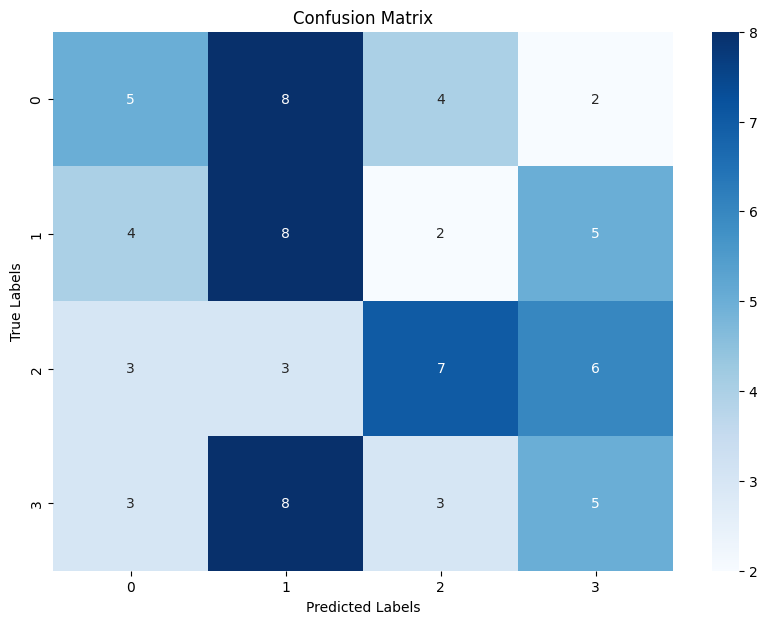

In [23]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()